In [50]:
import pickle
import numpy as np
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from scripts.utils import get_backend_properties_v1

# from blackwater.data.utils import (
#     generate_random_pauli_sum_op,
#     create_estimator_meas_data,
#     circuit_to_graph_data_json,
#     get_backend_properties_v1,
#     encode_pauli_sum_op,
#     create_meas_data_from_estimators
# )

from scripts.mlp import MLP1, MLP2, MLP3, encode_data

#from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from scripts.noise_utils import AddNoise, RemoveReadoutErrors

In [51]:
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data["train_data"], data["test_data"]

In [52]:
train_data, test_data = load_data("random_circ_paper_experiment_30_40.pkl")

In [53]:
from scripts.mlp import encode_data
from scripts.utils import get_backend_properties_v1
from qiskit.providers.fake_provider import FakeLima

backend = FakeLima()
properties = get_backend_properties_v1(backend=backend)

In [54]:
start = 30
end = 41

In [55]:
train_circuits = []
train_ideal_exp_vals = []
train_noisy_exp_vals = []
for i in range(start, end):
    for circ in train_data[i]:
        train_circuits.append(circ[0])
        train_ideal_exp_vals.append(circ[2])
        train_noisy_exp_vals.append(circ[3])

In [56]:
test_circuits = []
test_ideal_exp_vals = []
test_noisy_exp_vals = []
for i in range(start, end):
    for circ in test_data[i]:
        test_circuits.append(circ[0])
        test_ideal_exp_vals.append(circ[2])
        test_noisy_exp_vals.append(circ[3])

In [57]:
X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=4)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=4)

In [58]:
BATCH_SIZE = 32
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

In [59]:
from sklearn.ensemble import RandomForestRegressor

rfr_tree_list = []
for q in range(4):
    rfr = RandomForestRegressor(n_estimators=300)
    rfr.fit(X_train, y_train[:, q])
    rfr_tree_list.append(rfr)

In [60]:
X_train = pd.DataFrame(X_train)#.iloc[:, -4:]
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

RMSE_noisy_0: 0.22213340601866738
RMSE_mitigated_0: 0.18663513526370465
RMSE_noisy_1: 0.22190598175903098
RMSE_mitigated_1: 0.18676867563080432
RMSE_noisy_2: 0.21994984591526037
RMSE_mitigated_2: 0.1865672870973168
RMSE_noisy_3: 0.21442588130130005
RMSE_mitigated_3: 0.18310856366686853
RMSE_noisy: 0.21962576584947832
RMSE_mitigated: 0.18577628388385733


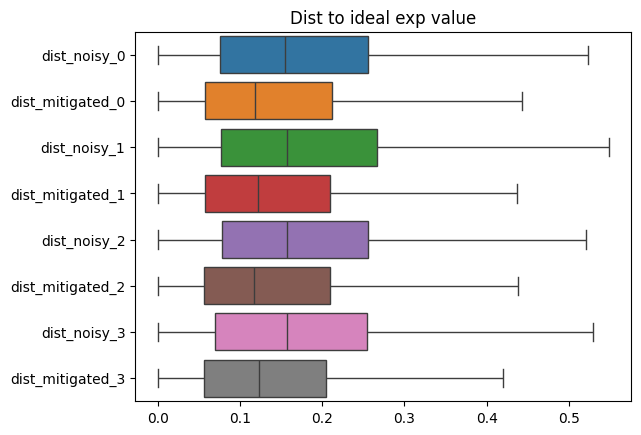

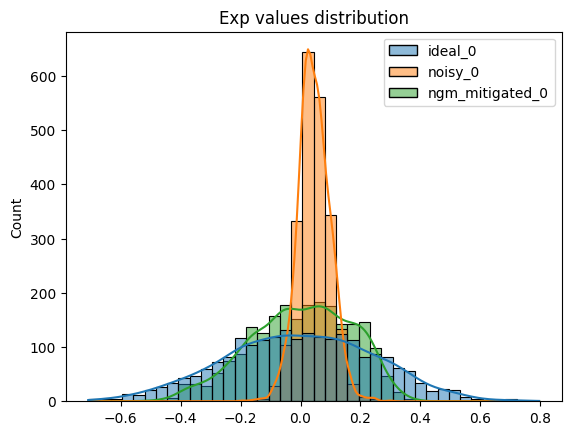

In [61]:
from scripts.mbd_utils import calc_imbalance

distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()
    # out = rfr.predict(batch_X[:, -4:])

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -4:].tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
        imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
        for q in range(4):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
                "imb_ideal": imbalance_ideal,
                "imb_noisy": imbalance_noisy,
                "imb_ngm": imbalance_mitigated,
                "imb_diff": imbalance_ideal - imbalance_mitigated
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [62]:
from scripts.from_circ_to_numpy import operations_to_features

X_train, y_train = operations_to_features(train_circuits, train_ideal_exp_vals, n_qubits=5, backend=backend)
X_test, y_test = operations_to_features(test_circuits, test_ideal_exp_vals, n_qubits=5, backend=backend)

In [73]:
from scripts.model import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
import json, os


sequence_input_size = 7
sequence_hidden_size = 4
sequence_num_layers = 4
sequence_model_type = 'LSTM'
sequence_dropout = 0.1
ann_hidden_layers = 2
ann_hidden_units = 64
ann_dropout = 0
noisy_first = True

num_epochs = 2

In [74]:
y_training = []
for y in range(4):
    temp = []
    for i in range(len(y_train)):
        temp.append(y_train[i][y])
    y_training.append(temp)

y_training = torch.tensor(y_training)

In [75]:
y_testing = []
for y in range(4):
    temp = []
    for i in range(len(y_test)):
        temp.append(y_test[i][y])
    y_testing.append(temp)

y_testing = torch.tensor(y_testing)

In [76]:
train_noisy_exp_vals = torch.tensor(train_noisy_exp_vals)
test_noisy_exp_vals = torch.tensor(test_noisy_exp_vals)

C:\Users\andre\AppData\Local\Temp\ipykernel_12552\653568998.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_noisy_exp_vals = torch.tensor(train_noisy_exp_vals)
C:\Users\andre\AppData\Local\Temp\ipykernel_12552\653568998.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_noisy_exp_vals = torch.tensor(test_noisy_exp_vals)


In [78]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
model_list = []
for q in range(4):
    sequence_model, ann = create_models(sequence_input_size, 
                                        sequence_hidden_size, 
                                        sequence_num_layers, 
                                        sequence_model_type, 
                                        sequence_dropout, 
                                        ann_hidden_layers, 
                                        ann_hidden_units, 
                                        ann_dropout, 
                                        noisy_first=noisy_first)
    loss_fn = nn.MSELoss() # leave for now
    optimizer = optim.Adam(list(ann.parameters()) + list(sequence_model.parameters()), lr=0.001)  

    train_losses, test_losses = train_and_test_step(sequence_model, ann, loss_fn, optimizer, X_train, train_noisy_exp_vals[:, q], y_training[q], X_test, test_noisy_exp_vals[:, q], y_testing[q], num_epochs, noisy_first=noisy_first)

    model_list.append((sequence_model, ann))

Epoch 1/2, train loss (PyTorch): 0.2097, test_loss (scikitlearn rmse): 0.1846
Epoch 2/2, train loss (PyTorch): 0.1854, test_loss (scikitlearn rmse): 0.1847
Epoch 1/2, train loss (PyTorch): 0.2080, test_loss (scikitlearn rmse): 0.1847
Epoch 2/2, train loss (PyTorch): 0.1851, test_loss (scikitlearn rmse): 0.1844
Epoch 1/2, train loss (PyTorch): 0.2096, test_loss (scikitlearn rmse): 0.1863
Epoch 2/2, train loss (PyTorch): 0.1870, test_loss (scikitlearn rmse): 0.2012
Epoch 1/2, train loss (PyTorch): 0.2120, test_loss (scikitlearn rmse): 0.1850
Epoch 2/2, train loss (PyTorch): 0.1820, test_loss (scikitlearn rmse): 0.1814


In [ ]:
y_test_tensor_proper = torch.ones(test_noisy_exp_vals.shape)
for i in range(len(y_test_tensor_proper)):
    for y in range(len(y_test_tensor_proper[0])):
        y_test_tensor_proper[i][y] = y_test[i][y]

RMSE_noisy_0: 0.22213340613079344
RMSE_mitigated_0: 0.18471497454145605
RMSE_noisy_1: 0.22190598176325388
RMSE_mitigated_1: 0.1850430704121476
RMSE_noisy_2: 0.2199498460440127
RMSE_mitigated_2: 0.18241832953299597
RMSE_noisy_3: 0.21442588134237137
RMSE_mitigated_3: 0.18315584192345877
RMSE_noisy: 0.2196257659211569
RMSE_mitigated: 0.18383625125890263


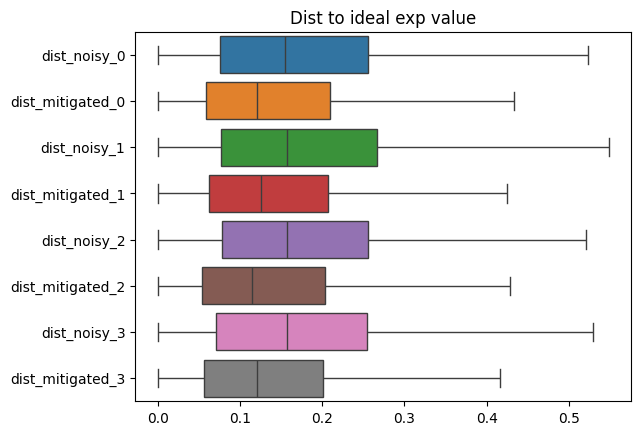

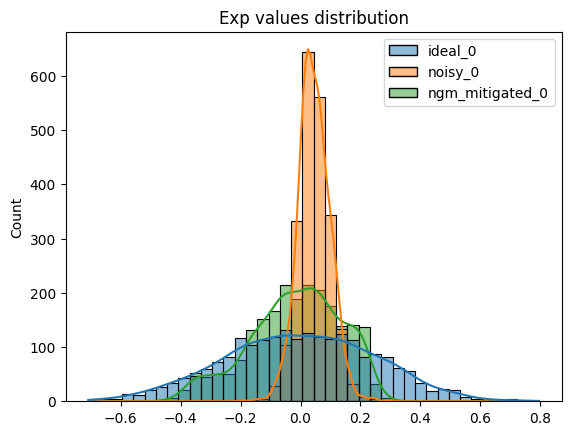

In [ ]:
distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

out = []
for q, model in enumerate(model_list):
    sequence_model = model[0]
    ann = model[1]
    model_output = []
    for i in range(len(X_test)):
        model_output.append(float(run_models(sequence_model, ann, X_test[i], test_noisy_exp_vals[i][q], noisy_first).detach().cpu().numpy()))
    out.append(model_output)
out = np.array(out).transpose()
# out = rfr.predict(batch_X[:, -4:])

for ideal, noisy, ngm_mitigated in zip(
    y_test_tensor_proper.tolist(),
    test_noisy_exp_vals.tolist(),
    out.tolist()
):
    imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
    imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
    imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
    for q in range(4):
        ideal_q = ideal[q]
        noisy_q = noisy[q]
        ngm_mitigated_q = ngm_mitigated[q]
        distances.append({
            f"ideal_{q}": ideal_q,
            f"noisy_{q}": noisy_q,
            f"ngm_mitigated_{q}": ngm_mitigated_q,
            f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
            f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
            f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
            f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            "imb_ideal": imbalance_ideal,
            "imb_noisy": imbalance_noisy,
            "imb_ngm": imbalance_mitigated,
            "imb_diff": imbalance_ideal - imbalance_mitigated
        })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()